# Laboratorio 4.1

Profesor: Joaquín Fontbona

Auxiliares: Bruno Hernández, Pablo Araya

Integrantes: Axel Álvarez, Diego Dominguez, Milan Cabezas

In [1]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import scipy as sp

# Problema 1: Regresión logística con gradiente estocástico

In [ ]:
#Fijar parámetros para gráficos
plt.rc('axes', titlesize=10)
plt.rc('legend', fontsize=15)  
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams.update({'font.size': 15,"axes.grid" : True})
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["figure.figsize"] = (15,7)

## 1. 
Se busca una interpretación geométrica sobre qué significa que $\sigma(w^Tx)\in (1/2, 1]$. Para esto, se grafica $\sigma(r)$ y luego se procederá a discutir lo pedido.

In [ ]:
R = np.linspace(-5,5,100)
Logistica = lambda r: 1/(1+np.exp(-r))

fig, ax = plt.subplots()
plt.plot(R,Logistica(R), label=r'$\sigma (r)= \frac{1}{1+exp(-r)}$')
ax.hlines(0.5,xmin=-5,xmax=5,color='red', label='$y=0.5$')
plt.title('Función logística/sigmoide $\sigma(r)$')
ax.set_xlabel('$r$')
plt.legend()
plt.show()

Con el gráfico se logra apreciar que la función $\sigma(r)$ toma valores en el intervalo $(1/2,1]$ cuando $r>0$ (estrictamente mayor), por lo que $\sigma(w^Tx)$ cuando $w^Tx=\langle a, x\rangle+b>0$, lo que a su vez implica que el vector $x$ queda por sobre el hiperplano definido por $w$ en $\mathbb{R}^{p+1}$. Esto se puede interpretar como que la función logistica $\phi(w^Tx)=\sigma(w^Tx)$ usada para atribuir el dato $x$ a la clase $C_1$ se "activa" en el intervalo $(1/2,1]$ cuando $w^Tx$ es positivo.

Es decir, $\sigma(w^Tx)\in (1/2,1]$ cuando el $w$ usado clasifica a $x$ en la clase $C_1$ a través de la funcion de activacion logística.

Luego, se pide expresar de manera explicita la distribucion de probabilidad $p(x|C_i)$ con $i=0,1$:

$$
p(x|C_i) = p(x|x\sim \mathcal{N}(\mu_i,\Sigma))= \frac{1}{(2\pi)^\frac{p}{2}|\Sigma|^\frac{1}{2}}exp\Big ( -\frac{1}{2}(x-\mu_i)^T\Sigma ^{-1}(x-\mu_i)  \Big )
$$

y con esto, es posible expresar $p(C_1|x)$ usando el teorema de bayes y probabilidades totales:
$$\begin{aligned}
p(C_1|x)&=\frac{p(x|C_1)p(C_1)}{p(x)}\\
&=\frac{p(x|C_1)p(C_1)}{p(x|C_1)p(C_1)+p(x|C_0)p(C_0)}\\
&=\frac{1}{1+(\frac{p(x|C_0)p(C_0)}{p(x|C_1)p(C_1)})}\\
&=\frac{1}{1+exp(-\bar r)}
\end{aligned}$$

donde

$$\begin{aligned}
\bar r &= ln(\frac{p(x|C_1)p(C_1)}{p(x|C_0)p(C_0)})\\
&= ln \Big(\frac{exp(-\frac{1}{2}(x-\mu_1)^T\Sigma ^{-1}(x-\mu_1))}{exp(-\frac{1}{2}(x-\mu_0)^T\Sigma ^{-1}(x-\mu_0))}\frac{p(C_1)}{p(C_0)}\Big)\\
&= -\frac{1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1)+\frac{1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0)+ln\Big(\frac{p(C_1)}{p(C_0)}\Big)\\
&= \frac{1}{2}\big(x^T\Sigma^{-1}(\mu_1-\mu_0)+(\mu_1-\mu_0)^T\Sigma^{-1}x-\mu_1^T\Sigma^{-1}\mu_1 + \mu_0^T\Sigma^{-1}\mu_0\big)+ln\Big(\frac{p(C_1)}{p(C_0)}\Big)\\
&= \Big[(\mu_1 - \mu_0)^T\Sigma^{-1}\Big]x + \Big[\frac{1}{2}(\mu_0^T\Sigma^{-1}\mu_0 - \mu_1^T\Sigma^{-1}\mu_1) + ln\Big(\frac{p(C_1)}{p(C_0)}\Big)\Big]
\end{aligned}$$

es posible resumir esta última expresión definiendo $a=\Sigma^{-1}(\mu_1 - \mu_0)$ y $b=\frac{1}{2}(\mu_0^T\Sigma^{-1}\mu_0 - \mu_1^T\Sigma^{-1}\mu_1)+ ln\Big(\frac{p(C_1)}{p(C_0)}\Big)$, con lo que queda $\bar r = a^Tx+b$ y 

$$
p(C_1|x)=\frac{1}{1+exp(-(a^Tx + b))}=\sigma(a^Tx+b)=\sigma(w^Tx)
$$
__Nota:__ En la última igualdad, se usa el mismo abuso de notación para $x$ que en el enunciado: $x=(x,1)\in \mathbb{R}^{p+1}$ .

## 2.
Ahora, se le dará una interpretación en terminos de __verosimilitud a posteriori__ a la siguiente expresión:
$$
L(w)=-\frac{1}{M}\displaystyle \sum_{m=1}^M y^{(m)}\cdot log\big (\sigma(w^Tx^{(m)})\big) + (1-y^{(m)})\cdot log\big(1-\sigma(w^Tx^{(m)})\big)
$$
considerando una función de activación logistica, y distribuciones condicionales como en la parte 1.

Primero, dado un $y^{(\bar m)}\in \{0,1\}$ fijo,  uno de los terminos que multiplican a los logaritmos dentro de la suma siempre valdrá 1 mientras que el otro valdrá 0. Con esto, vemos que si $w^Tx^{(\bar m)}>0$ implica que $\sigma(w^Tx^{(\bar m)})\in (1/2,1]$ o, equivalentemente, se clasifica el dato $x^{(\bar m)}$ (cuya etiqueta es $y^{(m)}$) en la clase $C_1$. Veamos que ocurre con $L(w)$ si, dado algún $w$, se clasifica mal a $x^{(\bar m)}$ (es decir, $w^Tx^{(\bar m)}>0$ siendo que $y^{(\bar m)}=0$):


$$\text{Para el término }\bar m \text{-ésimo de la suma} \\
\begin{aligned}
y^{(\bar m)}\cdot log(\sigma(w^Tx^{(\bar m)}) + (1-y^{(\bar m)})\cdot log(1-\sigma(x^Tx^{(\bar m)})&=0\cdot log(\sigma(w^Tx^{(\bar m)}) + 1\cdot log(1-\sigma(x^Tx^{(\bar m)})\\
&= log\big(1-\sigma(w^Tx^{(\bar m)})\big)\\
&< log\big(\sigma(w^Tx^{(\bar m)})\big)
\end{aligned}$$
algo similar ocurre en el caso inverso, es decir cuando $y^{(\bar m)}=1$ y $w^Tx^{(\bar m)}\leq 0$.

En resmen, si se comparan dos parámetros $w$ y $\bar w$ tales que $w$ clasifica mal un dato y $\bar w$ no (y clasifican de igual manera el resto de datos), entonces $L(w)>L(\bar w)$, por lo que buscar minimizar $L(w)$, y por ende maximizar la función de verosimilitud considerando cada vez más datos (verosimilitudes a posteriori), equivale a buscar el $w=(a,b)$ óptimio que clasifique de manera correcta la mayoria de los datos de entrenamiento.

# P2: Regresión Lineal

Dado un conjunto de $(x_i,y_i)_{i=1}^n \subset \mathbb{R}^m \times \mathbb{R}$, se propone la siguiente relación entre sus componentes:

\begin{equation}
     y = \theta^T x + \epsilon 
\end{equation}

en donde $\epsilon$ con valor esperado 0 y distribución desconocida. El problema de regresión lineal consiste en encontrar el parámetro $\theta$ tal que conjunto de datos satisfaga (1) de manera tal que Var($\epsilon$) sea lo más pequeña posible. Esto conlleva al problema de optimización:

\begin{equation} \hat{\theta} = \underset{\theta}{\arg\min}Var(\epsilon) = \underset{\theta}{\arg\min } ~ \mathbb{E} ((y- \theta^T x)^2) \end{equation}

Notemos que minimizar esta esperanza consiste en minimizar el error cuadrático medio (ECM) con respecto a $\theta$, que resulta ser una función convexa al componerse con el modelo de regresión lineal. Por lo tanto, este problema se puede abordar como el caso convexo del método de descenso de gradiente estocástico.

# 1)

In [2]:
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['PRICE'] = data.target

In [3]:
#Normalización y extensión de los datos
df_aux = df.drop('PRICE', axis = 1)
df_stan = (df_aux-df_aux.mean())/df_aux.std()
df_stan['b'] = 1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Se observa que la base de datos posee 506 filas y 14 columnas, es decir, hay 14 variables siendo una de ellas el "precio", que será nuestra variable objetivo.

# 2)

In [5]:
X=np.array(df_stan)
y=data.target
y=(y-y.mean())/y.std() #normalización del  precio

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)

Se separa los datos utilizando la función train_test_split, dando como resultado un conjunto de prueba y uno de entramiento, con una proporción de 80% y 20% respectivamente.

Esto realiza para poder observar como se comporta nuestro modelo al entregarle datos nuevos, para así ir ajustando los parámetros necesarios con el fin de obtener una buena estimación final.

# 3)

#### Implemente el algoritmo de descenso de gradiente estocástico para un modelo de regresión lineal, especificando cuál es la función de costos y su gradiente.

Función de costos: $F (\theta) = (y - \theta^T x)^2 \Leftrightarrow \sum_{i=1}^m f_i (\theta) = \sum_{i=1}^m (y_i - \theta^T x^{(i)})^2$

Gradiente: $\partial_{\theta_{i}} F(\theta) =  -2(y_i - \theta^T x^{(i)})x^{(i)}$

Se pide probar el algoritmo con al menos dos learning rates constante y dos variables.

Los learning rates variables que se utilizaran son los siguientes:

\begin{equation} \gamma_t = \frac{1}{t} ~, ~ ~  ~ ~ \gamma_t = \frac{|sen(\pi (t + \frac{1}{2})|}{\pi (t + \frac{1}{2})} \end{equation}

Claramente el primer learning rate cumple la condición de $\sum_{t \in \mathbb{N}} \gamma_t = \infty $ y  $\sum_{t \in \mathbb{N}} \gamma_t^2 < \infty $

Para el segundo caso, se tiene que:

\begin{equation} \frac{|sen(\pi (t + \frac{1}{2})|^2}{(\pi (t + \frac{1}{2}))^2} \leq \frac{1}{(\pi (t + \frac{1}{2}))^2} \Longrightarrow \sum_{t \in \mathbb{N}} \frac{|sen(\pi (t + \frac{1}{2})|^2}{(\pi (t + \frac{1}{2}))^2} \leq \sum_{t \in \mathbb{N}} \frac{1}{(\pi (t + \frac{1}{2}))^2} = \frac{1}{\pi^2}\sum_{t \in \mathbb{N}} \frac{1}{(t + \frac{1}{2})^2} < \infty \end{equation} 

Luego, para ver que la suma diverge se realiza lo siguiente:

En primer lugar, notemos que: 
\begin{equation}|sen(\pi (t + \frac{1}{2})| = |sen(\pi t + \frac{\pi}{2})| = |sen(\pi t)cos(\frac{\pi}{2}) + cos(\pi t )sen(\frac{\pi}{2})| = |sen(\pi t)\cdot 0 + cos(\pi t) \cdot 1| = |cos(\pi t)| = 1 ~ ~ \forall t \in \mathbb{N}\end{equation}

\begin{equation}\Longrightarrow \sum_{t \in \mathbb{N}} \frac{|sen(\pi (t + \frac{1}{2})|}{\pi (t + \frac{1}{2})} = 
\sum_{t \in \mathbb{N}} \frac{1}{\pi (t + \frac{1}{2})} = \infty \end{equation}

Por lo tanto, este último $\gamma_t$ satisface la condiciones que garantiza la convergencia c.s. de $\theta_t$ en el caso convexo del método SGD.

In [60]:
#Implementación del algoritmo
def SGD(X,y,theta,gamma,n):
    m = len(y)
    theta_t=theta.copy()
    Theta=np.empty(n,dtype=object)
    for t in range(1,n):
        d= {'1/t': 1/t, 'sin': abs((math.sin(math.pi*(t+0.5)))/(math.pi*(t+0.5)))}
        g = lambda gamma : gamma if type(gamma) in [float,int] else d[gamma]
        i=np.random.randint(0,m)
        X_i = X[i,:]
        y_i = y[i]
        y_p = np.dot(theta_t,X_i)
        grad= -2*(y_i - y_p)*X_i
        
        theta_t=theta_t - g(gamma)*grad
        Theta[t]=theta_t
    Theta[0]=theta
    return Theta

In [61]:
#Parametros de entrada
gamma1 = 0.0001
gamma2 = 0.01
gamma3 = '1/t'
gamma4 = 'sin'
n = 10000
theta=np.random.uniform(0,1,14)

In [62]:
new_theta1=SGD(X_train,y_train,theta,gamma1,n)
new_theta2=SGD(X_train,y_train,theta,gamma2,n)
new_theta3=SGD(X_train,y_train,theta,gamma3,n)
new_theta4=SGD(X_train,y_train,theta,gamma4,n)

In [63]:
#Variables para graficar
ECM1=np.zeros(n)
ECM2=np.zeros(n)
ECM3=np.zeros(n)
ECM4=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_theta1[k])
    y_pred2 = np.matmul(X_test,new_theta2[k])
    y_pred3 = np.matmul(X_test,new_theta3[k])
    y_pred4 = np.matmul(X_test,new_theta4[k])
    ECM1[k]=mean_squared_error(y_test, y_pred1)
    ECM2[k]=mean_squared_error(y_test, y_pred2)
    ECM3[k]=mean_squared_error(y_test, y_pred3)
    ECM4[k]=mean_squared_error(y_test, y_pred4)

In [64]:
print(min(ECM1))
print(min(ECM2))
print(min(ECM3))
print(min(ECM4))

0.8813089382675728
0.37209342835113346
10.086103126624566
0.5452057514660502


Notación: $h(t) = \frac{|sen(\pi (t + \frac{1}{2})|}{\pi (t + \frac{1}{2})}$

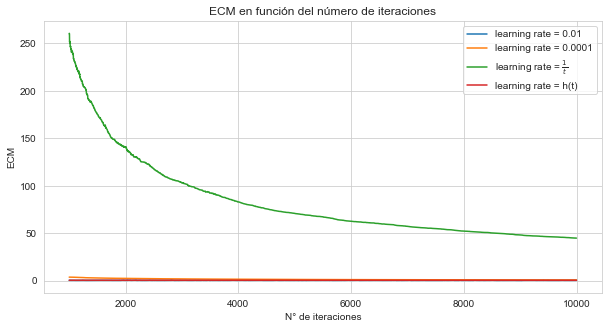

In [67]:
#Gráfico
plt.figure(figsize=[10,5])
sns.set_style('whitegrid')
N_=np.arange(1000,n)
plt.plot(N_,ECM2[1000:,],label='learning rate = '+str(gamma2))
plt.plot(N_,ECM1[1000:,],label='learning rate = '+str(gamma1))
plt.plot(N_,ECM3[1000:,],label=r'learning rate = $\frac{1}{t}$')
plt.plot(N_,ECM4[1000:,],label='learning rate = h(t)')
plt.xlabel('N° de iteraciones')
plt.ylabel('ECM')
plt.title('ECM en función del número de iteraciones')
plt.legend()

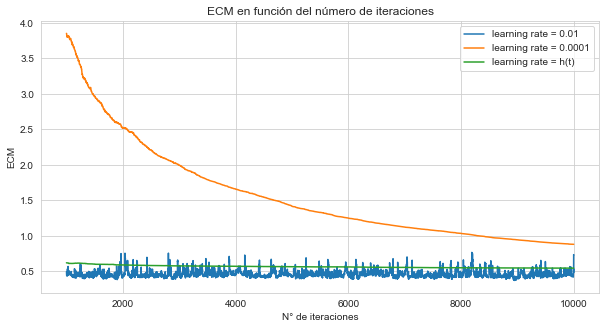

In [66]:
plt.figure(figsize=[10,5])
sns.set_style('whitegrid')
N_=np.arange(1000,n)
plt.plot(N_,ECM2[1000:,],label='learning rate = '+str(gamma2))
plt.plot(N_,ECM1[1000:,],label='learning rate = '+str(gamma1))
plt.plot(N_,ECM4[1000:,],label='learning rate = h(t)')
plt.xlabel('N° de iteraciones')
plt.ylabel('ECM')
plt.title('ECM en función del número de iteraciones')
plt.legend()

In [14]:
#Predicciones
y_pred1 = np.matmul(X_test,new_theta1[-1])
y_pred2 = np.matmul(X_test,new_theta2[-1])
y_pred3 = np.matmul(X_test,new_theta3[-1])
y_pred4 = np.matmul(X_test,new_theta4[-1])
y_pred4 = np.matmul(X_test,new_theta4[-1])

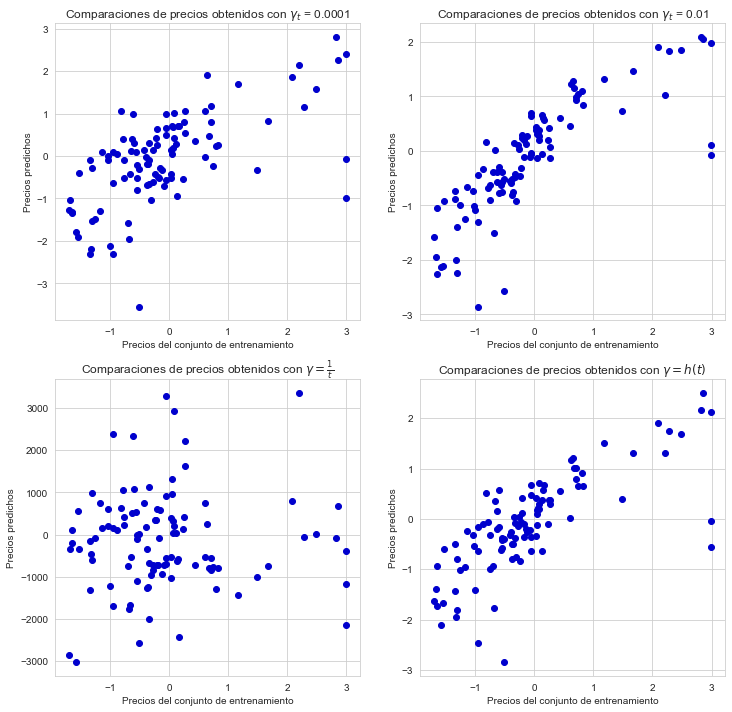

In [15]:
#Gráficos
fig, axes = plt.subplots(2, 2, figsize=(12,12))
axes[0,0].set_title('Comparaciones de precios obtenidos con $\gamma_t$ = '+str(gamma1))
axes[0,0].plot(y_test,y_pred1, 'o', color='mediumblue')
axes[0,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,0].set_ylabel('Precios predichos');

axes[0,1].set_title('Comparaciones de precios obtenidos con $\gamma_t$ = '+str(gamma2))
axes[0,1].plot(y_test,y_pred2, 'o', color='mediumblue')
axes[0,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,1].set_ylabel('Precios predichos');

axes[1,0].set_title(r'Comparaciones de precios obtenidos con $\gamma = \frac{1}{t}$' )
axes[1,0].plot(y_test,y_pred3, 'o', color='mediumblue')
axes[1,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,0].set_ylabel('Precios predichos');

axes[1,1].set_title(r'Comparaciones de precios obtenidos con $\gamma = h(t)$' )
axes[1,1].plot(y_test,y_pred4, 'o', color='mediumblue')
axes[1,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,1].set_ylabel('Precios predichos');

# 4)

####  Modifique el algoritmo anterior para trabajar con mini-batch. Pruebe el desempeño (nuevamente en términos del error cuadrático medio para el conjunto de prueba) del algoritmo para distintos tamaños de mini-batch y learning rates y justifique cual es el mejor ¿Existe alguna relación entre ambos parámetros?

In [16]:
def mini_batch(X,y,theta,gamma,n,M):
    m = len(y)
    theta_t=theta.copy()
    Theta=np.empty(n,dtype=object)
    for t in range(1,n):
        suma=0
        d= {'1/t': 1/t, 'sin': abs((math.sin(math.pi*(t+0.5)))/(math.pi*(t+0.5)))}
        g = lambda gamma : gamma if type(gamma) in [float,int] else d[gamma]
        for k in range(M):
            i = np.random.randint(0,m)
            X_i = X[i,:]
            y_i = y[i]
            y_p = np.dot(theta_t,X_i)
            grad_i= -2*(y_i - y_p)*X_i
            suma+=grad_i
            
        theta_t = theta_t - g(gamma)*(1/M)*suma
        Theta[t]=theta_t
    Theta[0]=theta
    return Theta

In [17]:
#Parametros de entrada
gamma1 = 0.0001
gamma2 = 0.01
gamma3 = '1/t'
gamma4 = 'sin'
n = 10000
M1=10 
M2=len(y_test)
M3=202
M4=len(y)

In [18]:
#Fijando el learning rate y variando M
new_thetaM1_g1=mini_batch(X_train,y_train,theta,gamma1,n,M1)
new_thetaM2_g1=mini_batch(X_train,y_train,theta,gamma1,n,M2)
new_thetaM3_g1=mini_batch(X_train,y_train,theta,gamma1,n,M3)
new_thetaM4_g1=mini_batch(X_train,y_train,theta,gamma1,n,M4)

In [19]:
new_thetaM1_g2=mini_batch(X_train,y_train,theta,gamma2,n,M1)
new_thetaM2_g2=mini_batch(X_train,y_train,theta,gamma2,n,M2)
new_thetaM3_g2=mini_batch(X_train,y_train,theta,gamma2,n,M3)
new_thetaM4_g2=mini_batch(X_train,y_train,theta,gamma2,n,M4)

In [20]:
new_thetaM1_g3=mini_batch(X_train,y_train,theta,gamma3,n,M1)
new_thetaM2_g3=mini_batch(X_train,y_train,theta,gamma3,n,M2)
new_thetaM3_g3=mini_batch(X_train,y_train,theta,gamma3,n,M3)
new_thetaM4_g3=mini_batch(X_train,y_train,theta,gamma3,n,M4)

In [21]:
new_thetaM1_g4=mini_batch(X_train,y_train,theta,gamma4,n,M1)
new_thetaM2_g4=mini_batch(X_train,y_train,theta,gamma4,n,M2)
new_thetaM3_g4=mini_batch(X_train,y_train,theta,gamma4,n,M3)
new_thetaM4_g4=mini_batch(X_train,y_train,theta,gamma4,n,M4)

In [22]:
#Variables auxiliares para graficar
ECM_M1_g1=np.zeros(n)
ECM_M2_g1=np.zeros(n)
ECM_M3_g1=np.zeros(n)
ECM_M4_g1=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_thetaM1_g1[k])
    y_pred2 = np.matmul(X_test,new_thetaM2_g1[k])
    y_pred3 = np.matmul(X_test,new_thetaM3_g1[k])
    y_pred4 = np.matmul(X_test,new_thetaM4_g1[k])
    ECM_M1_g1[k]=mean_squared_error(y_test, y_pred1)
    ECM_M2_g1[k]=mean_squared_error(y_test, y_pred2)
    ECM_M3_g1[k]=mean_squared_error(y_test, y_pred3)
    ECM_M4_g1[k]=mean_squared_error(y_test, y_pred4)

In [23]:
ECM_M1_g2=np.zeros(n)
ECM_M2_g2=np.zeros(n)
ECM_M3_g2=np.zeros(n)
ECM_M4_g2=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_thetaM1_g2[k])
    y_pred2 = np.matmul(X_test,new_thetaM2_g2[k])
    y_pred3 = np.matmul(X_test,new_thetaM3_g2[k])
    y_pred4 = np.matmul(X_test,new_thetaM4_g2[k])
    ECM_M1_g2[k]=mean_squared_error(y_test, y_pred1)
    ECM_M2_g2[k]=mean_squared_error(y_test, y_pred2)
    ECM_M3_g2[k]=mean_squared_error(y_test, y_pred3)
    ECM_M4_g2[k]=mean_squared_error(y_test, y_pred4)

In [24]:
ECM_M1_g3=np.zeros(n)
ECM_M2_g3=np.zeros(n)
ECM_M3_g3=np.zeros(n)
ECM_M4_g3=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_thetaM1_g3[k])
    y_pred2 = np.matmul(X_test,new_thetaM2_g3[k])
    y_pred3 = np.matmul(X_test,new_thetaM3_g3[k])
    y_pred4 = np.matmul(X_test,new_thetaM4_g3[k])
    ECM_M1_g3[k]=mean_squared_error(y_test, y_pred1)
    ECM_M2_g3[k]=mean_squared_error(y_test, y_pred2)
    ECM_M3_g3[k]=mean_squared_error(y_test, y_pred3)
    ECM_M4_g3[k]=mean_squared_error(y_test, y_pred4)

In [25]:
ECM_M1_g4=np.zeros(n)
ECM_M2_g4=np.zeros(n)
ECM_M3_g4=np.zeros(n)
ECM_M4_g4=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_thetaM1_g4[k])
    y_pred2 = np.matmul(X_test,new_thetaM2_g4[k])
    y_pred3 = np.matmul(X_test,new_thetaM3_g4[k])
    y_pred4 = np.matmul(X_test,new_thetaM4_g4[k])
    ECM_M1_g4[k]=mean_squared_error(y_test, y_pred1)
    ECM_M2_g4[k]=mean_squared_error(y_test, y_pred2)
    ECM_M3_g4[k]=mean_squared_error(y_test, y_pred3)
    ECM_M4_g4[k]=mean_squared_error(y_test, y_pred4)

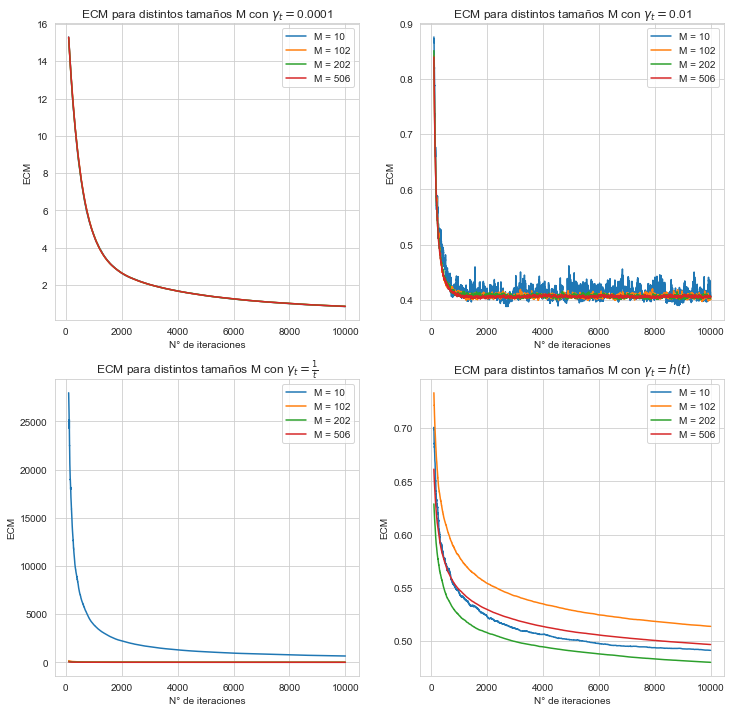

In [26]:
#Gráficos
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(12,12))
N_=np.arange(100,n)
axes[0,0].set_title(r"ECM para distintos tamaños M con $\gamma_t = $"+str(gamma1))
axes[0,0].plot(N_,ECM_M1_g1[100:,],label='M = '+str(M1));
axes[0,0].plot(N_,ECM_M2_g1[100:,],label='M = '+str(M2));
axes[0,0].plot(N_,ECM_M3_g1[100:,],label='M = '+str(M3));
axes[0,0].plot(N_,ECM_M4_g1[100:,],label='M = '+str(M4));
axes[0,0].set_xlabel('N° de iteraciones');
axes[0,0].set_ylabel('ECM');
axes[0,0].legend(loc='best');

axes[0,1].set_title(r"ECM para distintos tamaños M con $\gamma_t = $"+str(gamma2))
axes[0,1].plot(N_,ECM_M1_g2[100:,],label='M = '+str(M1));
axes[0,1].plot(N_,ECM_M2_g2[100:,],label='M = '+str(M2));
axes[0,1].plot(N_,ECM_M3_g2[100:,],label='M = '+str(M3));
axes[0,1].plot(N_,ECM_M4_g2[100:,],label='M = '+str(M4));
axes[0,1].set_xlabel('N° de iteraciones');
axes[0,1].set_ylabel('ECM');
axes[0,1].legend(loc='best');

axes[1,0].set_title(r"ECM para distintos tamaños M con $\gamma_t = \frac{1}{t}$")
axes[1,0].plot(N_,ECM_M1_g3[100:,],label='M = '+str(M1));
axes[1,0].plot(N_,ECM_M2_g3[100:,],label='M = '+str(M2));
axes[1,0].plot(N_,ECM_M3_g3[100:,],label='M = '+str(M3));
axes[1,0].plot(N_,ECM_M4_g3[100:,],label='M = '+str(M4));
axes[1,0].set_xlabel('N° de iteraciones');
axes[1,0].set_ylabel('ECM');
axes[1,0].legend(loc='best');

axes[1,1].set_title(r"ECM para distintos tamaños M con $\gamma_t = h(t)$")
axes[1,1].plot(N_,ECM_M1_g4[100:,],label='M = '+str(M1));
axes[1,1].plot(N_,ECM_M2_g4[100:,],label='M = '+str(M2));
axes[1,1].plot(N_,ECM_M3_g4[100:,],label='M = '+str(M3));
axes[1,1].plot(N_,ECM_M4_g4[100:,],label='M = '+str(M4));
axes[1,1].set_xlabel('N° de iteraciones');
axes[1,1].set_ylabel('ECM');
axes[1,1].legend(loc='best');

In [27]:
#print(ECM1[-1])
#print(ECM2[-1])
#print(ECM3[-1])
#print(ECM4[-1])

In [28]:
#Predicciones
y_pred_M1_g1 = np.matmul(X_test,new_thetaM1_g1[-1])
y_pred_M2_g1 = np.matmul(X_test,new_thetaM2_g1[-1])
y_pred_M3_g1 = np.matmul(X_test,new_thetaM3_g1[-1])
y_pred_M4_g1 = np.matmul(X_test,new_thetaM4_g1[-1])

In [29]:
y_pred_M1_g2 = np.matmul(X_test,new_thetaM1_g2[-1])
y_pred_M2_g2 = np.matmul(X_test,new_thetaM2_g2[-1])
y_pred_M3_g2 = np.matmul(X_test,new_thetaM3_g2[-1])
y_pred_M4_g2 = np.matmul(X_test,new_thetaM4_g2[-1])

In [30]:
y_pred_M1_g3 = np.matmul(X_test,new_thetaM1_g3[-1])
y_pred_M2_g3 = np.matmul(X_test,new_thetaM2_g3[-1])
y_pred_M3_g3 = np.matmul(X_test,new_thetaM3_g3[-1])
y_pred_M4_g3 = np.matmul(X_test,new_thetaM4_g3[-1])

In [31]:
y_pred_M1_g4 = np.matmul(X_test,new_thetaM1_g4[-1])
y_pred_M2_g4 = np.matmul(X_test,new_thetaM2_g4[-1])
y_pred_M3_g4 = np.matmul(X_test,new_thetaM3_g4[-1])
y_pred_M4_g4 = np.matmul(X_test,new_thetaM4_g4[-1])

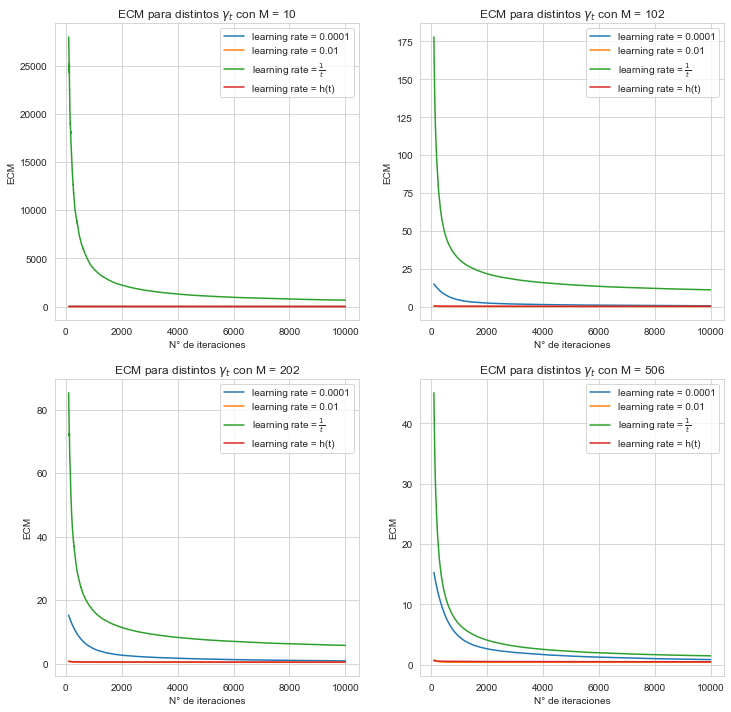

In [32]:
#Gráficos
fig, axes = plt.subplots(2, 2, figsize=(12,12))
j=100
N_=np.arange(j,n)
axes[0,0].set_title(r"ECM para distintos $\gamma_t$ con M = "+str(M1))
axes[0,0].plot(N_,ECM_M1_g1[j:,],label='learning rate = '+str(gamma1));
axes[0,0].plot(N_,ECM_M1_g2[j:,],label='learning rate = '+str(gamma2));
axes[0,0].plot(N_,ECM_M1_g3[j:,],label=r'learning rate = $\frac{1}{t}$');
axes[0,0].plot(N_,ECM_M1_g4[j:,],label='learning rate = h(t)');
axes[0,0].set_xlabel('N° de iteraciones');
axes[0,0].set_ylabel('ECM');
axes[0,0].legend(loc='best');

axes[0,1].set_title(r"ECM para distintos $\gamma_t$ con M = "+str(M2))
axes[0,1].plot(N_,ECM_M2_g1[j:,],label='learning rate = '+str(gamma1));
axes[0,1].plot(N_,ECM_M2_g2[j:,],label='learning rate = '+str(gamma2));
axes[0,1].plot(N_,ECM_M2_g3[j:,],label=r'learning rate = $\frac{1}{t}$');
axes[0,1].plot(N_,ECM_M2_g4[j:,],label='learning rate = h(t)');
axes[0,1].set_xlabel('N° de iteraciones');
axes[0,1].set_ylabel('ECM');
axes[0,1].legend(loc='best');

axes[1,0].set_title(r"ECM para distintos $\gamma_t$ con M = "+str(M3))
axes[1,0].plot(N_,ECM_M3_g1[j:,],label='learning rate = '+str(gamma1));
axes[1,0].plot(N_,ECM_M3_g2[j:,],label='learning rate = '+str(gamma2));
axes[1,0].plot(N_,ECM_M3_g3[j:,],label=r'learning rate = $\frac{1}{t}$');
axes[1,0].plot(N_,ECM_M3_g4[j:,],label='learning rate = h(t)');
axes[1,0].set_xlabel('N° de iteraciones');
axes[1,0].set_ylabel('ECM');
axes[1,0].legend(loc='best');

axes[1,1].set_title(r"ECM para distintos $\gamma_t$ con M = "+str(M4))
axes[1,1].plot(N_,ECM_M4_g1[j:,],label='learning rate = '+str(gamma1));
axes[1,1].plot(N_,ECM_M4_g2[j:,],label='learning rate = '+str(gamma2));
axes[1,1].plot(N_,ECM_M4_g3[j:,],label=r'learning rate = $\frac{1}{t}$');
axes[1,1].plot(N_,ECM_M4_g4[j:,],label='learning rate = h(t)');
axes[1,1].set_xlabel('N° de iteraciones');
axes[1,1].set_ylabel('ECM');
axes[1,1].legend(loc='best');

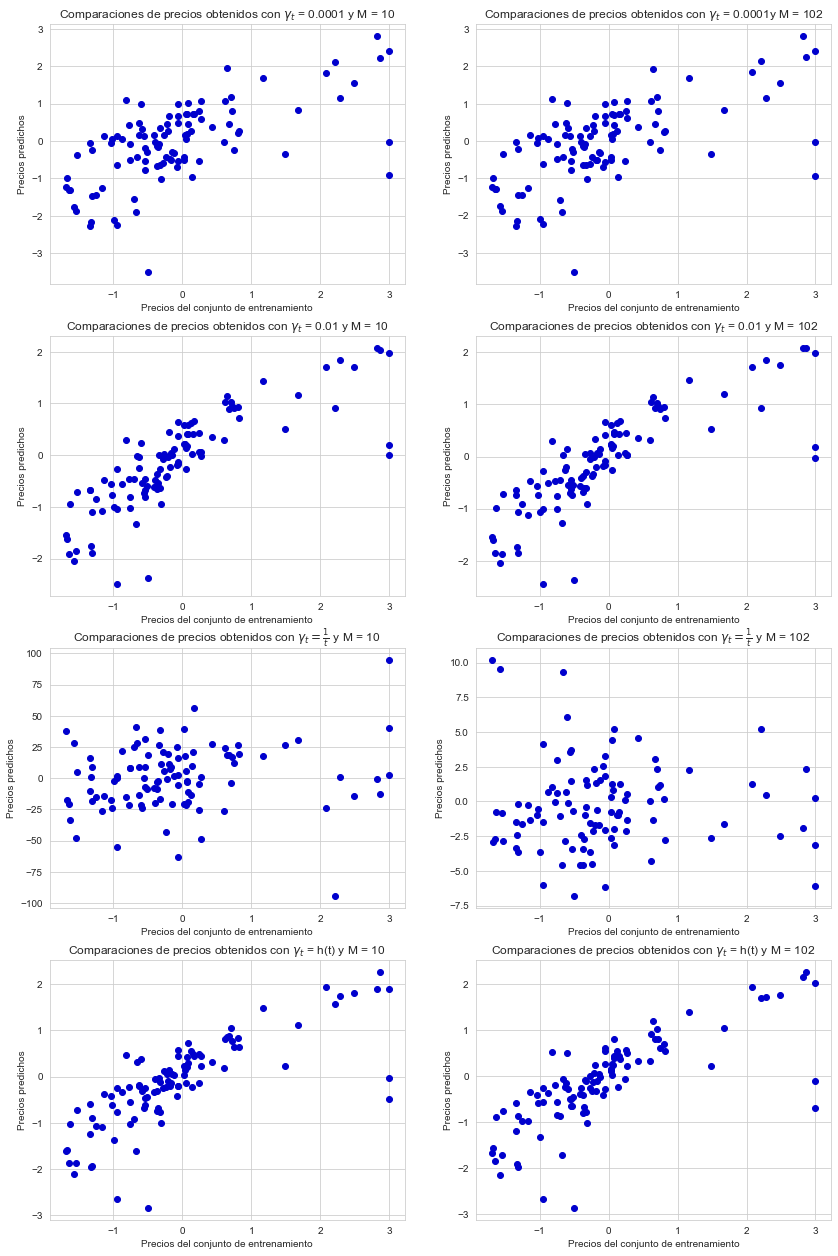

In [33]:
#Gráficos
fig, axes = plt.subplots(4, 2, figsize=(14,22))
axes[0,0].set_title(r'Comparaciones de precios obtenidos con $\gamma_t$ = '+str(gamma1)+" y M = "+str(M1))
axes[0,0].plot(y_test,y_pred_M1_g1, 'o', color='mediumblue')
axes[0,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,0].set_ylabel('Precios predichos');

axes[0,1].set_title(r'Comparaciones de precios obtenidos con $\gamma_t$ = '+str(gamma1)+"y M = "+str(M2))
axes[0,1].plot(y_test,y_pred_M2_g1, 'o', color='mediumblue')
axes[0,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,1].set_ylabel('Precios predichos');

axes[1,0].set_title(r'Comparaciones de precios obtenidos con $\gamma_t$ = '+str(gamma2)+" y M = "+str(M1))
axes[1,0].plot(y_test,y_pred_M1_g2, 'o', color='mediumblue')
axes[1,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,0].set_ylabel('Precios predichos');

axes[1,1].set_title(r'Comparaciones de precios obtenidos con $\gamma_t$ = '+str(gamma2)+" y M = "+str(M2))
axes[1,1].plot(y_test,y_pred_M2_g2, 'o', color='mediumblue')
axes[1,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,1].set_ylabel('Precios predichos');

axes[2,0].set_title(r'Comparaciones de precios obtenidos con $\gamma_t = \frac{1}{t}$ y M = '+str(M1))
axes[2,0].plot(y_test,y_pred_M1_g3, 'o', color='mediumblue')
axes[2,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[2,0].set_ylabel('Precios predichos');

axes[2,1].set_title(r'Comparaciones de precios obtenidos con $\gamma_t = \frac{1}{t}$ y M = '+str(M2))
axes[2,1].plot(y_test,y_pred_M2_g3, 'o', color='mediumblue')
axes[2,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[2,1].set_ylabel('Precios predichos');

axes[3,0].set_title(r'Comparaciones de precios obtenidos con $\gamma_t$ = h(t) y M = '+str(M1))
axes[3,0].plot(y_test,y_pred_M1_g4, 'o', color='mediumblue')
axes[3,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[3,0].set_ylabel('Precios predichos');

axes[3,1].set_title(r'Comparaciones de precios obtenidos con $\gamma_t$ = h(t) y M = '+str(M2))
axes[3,1].plot(y_test,y_pred_M2_g4, 'o', color='mediumblue')
axes[3,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[3,1].set_ylabel('Precios predichos');

# 5)

a) Momentum: \\
El método consiste en ir generando los pasos de descenso como
\begin{equation} m_{i} = \beta m_{i-1} + (1-\beta)\nabla_{\theta}f(\theta_{i},x_{i}),~ m_0 = 0, ~ \beta \in (0,1)\end{equation}

talque $\theta_{i+1} = \theta_{i} - \eta \cdot m_{i} $


In [34]:
def momentum(X,y,theta,gamma,n,B):
    m = len(y)
    theta_t=theta.copy()
    m_t=0
    Theta=np.empty(n,dtype=object)
    for t in range(1,n):
        d= {'1/t': 1/t, 'sin': abs((math.sin(math.pi*(t+0.5)))/(math.pi*(t+0.5)))}
        g = lambda gamma : gamma if type(gamma) in [float,int] else d[gamma]
        i=np.random.randint(0,m)
        X_i = X[i,:]
        y_i = y[i]
        y_p = np.dot(theta_t,X_i)
        grad= -2*(y_i - y_p)*X_i
        m_t = B*m_t+(1-B)*grad
        
        theta_t=theta_t - g(gamma)*m_t
        Theta[t]=theta_t
    Theta[0]=theta
    return Theta

In [35]:
n = 10000
gamma1 = 0.0001
gamma2 = 0.01
gamma3 = 0.5
B1 = 0.9
B2 = 0.5
B3 = 0.1
B4 = 0.001

In [36]:
new_theta_B1_g1=momentum(X_train,y_train,theta,gamma1,n,B1)
new_theta_B2_g1=momentum(X_train,y_train,theta,gamma1,n,B2)
new_theta_B3_g1=momentum(X_train,y_train,theta,gamma1,n,B3)
new_theta_B4_g1=momentum(X_train,y_train,theta,gamma1,n,B4)

In [37]:
new_theta_B1_g2=momentum(X_train,y_train,theta,gamma2,n,B1)
new_theta_B2_g2=momentum(X_train,y_train,theta,gamma2,n,B2)
new_theta_B3_g2=momentum(X_train,y_train,theta,gamma2,n,B3)
new_theta_B4_g2=momentum(X_train,y_train,theta,gamma2,n,B4)

In [38]:
ECM_B1_g1=np.zeros(n)
ECM_B2_g1=np.zeros(n)
ECM_B3_g1=np.zeros(n)
ECM_B4_g1=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_theta_B1_g1[k])
    y_pred2 = np.matmul(X_test,new_theta_B2_g1[k])
    y_pred3 = np.matmul(X_test,new_theta_B3_g1[k])
    y_pred4 = np.matmul(X_test,new_theta_B4_g1[k])
    ECM_B1_g1[k]=mean_squared_error(y_test, y_pred1)
    ECM_B2_g1[k]=mean_squared_error(y_test, y_pred2)
    ECM_B3_g1[k]=mean_squared_error(y_test, y_pred3)
    ECM_B4_g1[k]=mean_squared_error(y_test, y_pred4)

In [39]:
ECM_B1_g2=np.zeros(n)
ECM_B2_g2=np.zeros(n)
ECM_B3_g2=np.zeros(n)
ECM_B4_g2=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_theta_B1_g2[k])
    y_pred2 = np.matmul(X_test,new_theta_B2_g2[k])
    y_pred3 = np.matmul(X_test,new_theta_B3_g2[k])
    y_pred4 = np.matmul(X_test,new_theta_B4_g2[k])
    ECM_B1_g2[k]=mean_squared_error(y_test, y_pred1)
    ECM_B2_g2[k]=mean_squared_error(y_test, y_pred2)
    ECM_B3_g2[k]=mean_squared_error(y_test, y_pred3)
    ECM_B4_g2[k]=mean_squared_error(y_test, y_pred4)

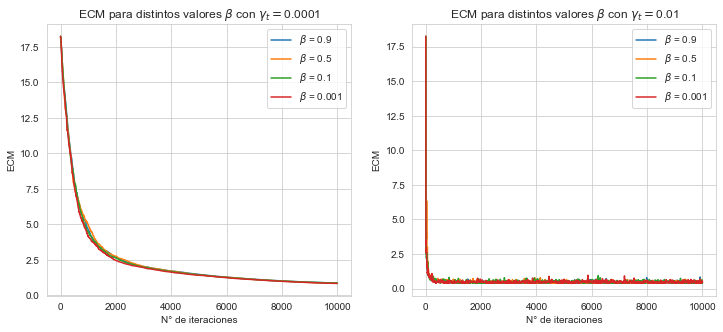

In [40]:
#Gráficos
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12,5))
j=0
N_=np.arange(j,n)
axes[0].set_title(r"ECM para distintos valores $\beta$ con $\gamma_t = $"+str(gamma1))
axes[0].plot(N_,ECM_B1_g1[j:,],label=r'$\beta$ = '+str(B1));
axes[0].plot(N_,ECM_B2_g1[j:,],label=r'$\beta$ = '+str(B2));
axes[0].plot(N_,ECM_B3_g1[j:,],label=r'$\beta$ = '+str(B3));
axes[0].plot(N_,ECM_B4_g1[j:,],label=r'$\beta$ = '+str(B4));
axes[0].set_xlabel('N° de iteraciones');
axes[0].set_ylabel('ECM');
axes[0].legend(loc='best');

axes[1].set_title(r"ECM para distintos valores $\beta$ con $\gamma_t = $"+str(gamma2))
axes[1].plot(N_,ECM_B1_g2[j:,],label=r'$\beta$ = '+str(B1));
axes[1].plot(N_,ECM_B2_g2[j:,],label=r'$\beta$ = '+str(B2));
axes[1].plot(N_,ECM_B3_g2[j:,],label=r'$\beta$ = '+str(B3));
axes[1].plot(N_,ECM_B4_g2[j:,],label=r'$\beta$ = '+str(B4));
axes[1].set_xlabel('N° de iteraciones');
axes[1].set_ylabel('ECM');
axes[1].legend(loc='best');

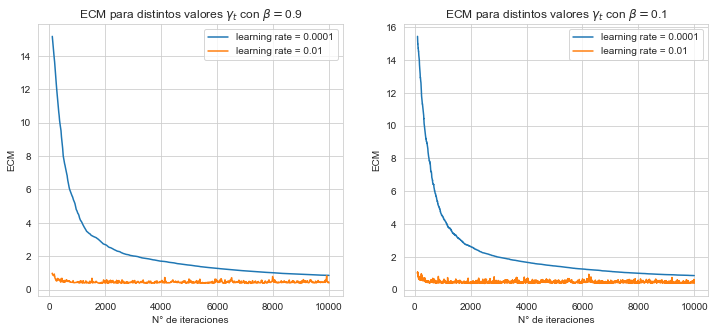

In [41]:
#Gráficos
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12,5))
N_=np.arange(100,n)
axes[0].set_title(r"ECM para distintos valores $\gamma_t$ con $\beta = $"+str(B1))
axes[0].plot(N_,ECM_B1_g1[100:,],label='learning rate = '+str(gamma1));
axes[0].plot(N_,ECM_B1_g2[100:,],label='learning rate = '+str(gamma2));
axes[0].set_xlabel('N° de iteraciones');
axes[0].set_ylabel('ECM');
axes[0].legend(loc='best');

axes[1].set_title(r"ECM para distintos valores $\gamma_t$ con $\beta = $"+str(B3))
axes[1].plot(N_,ECM_B3_g1[100:,],label='learning rate = '+str(gamma1));
axes[1].plot(N_,ECM_B3_g2[100:,],label='learning rate = '+str(gamma2));
axes[1].set_xlabel('N° de iteraciones');
axes[1].set_ylabel('ECM');
axes[1].legend(loc='best');

In [42]:
y_pred_B1_g1 = np.matmul(X_test,new_theta_B1_g1[-1])
y_pred_B2_g1 = np.matmul(X_test,new_theta_B2_g1[-1])
y_pred_B3_g1 = np.matmul(X_test,new_theta_B3_g1[-1])
y_pred_B4_g1 = np.matmul(X_test,new_theta_B4_g1[-1])

In [43]:
y_pred_B1_g2 = np.matmul(X_test,new_theta_B1_g2[-1])
y_pred_B2_g2 = np.matmul(X_test,new_theta_B2_g2[-1])
y_pred_B3_g2 = np.matmul(X_test,new_theta_B3_g2[-1])
y_pred_B4_g2 = np.matmul(X_test,new_theta_B4_g2[-1])

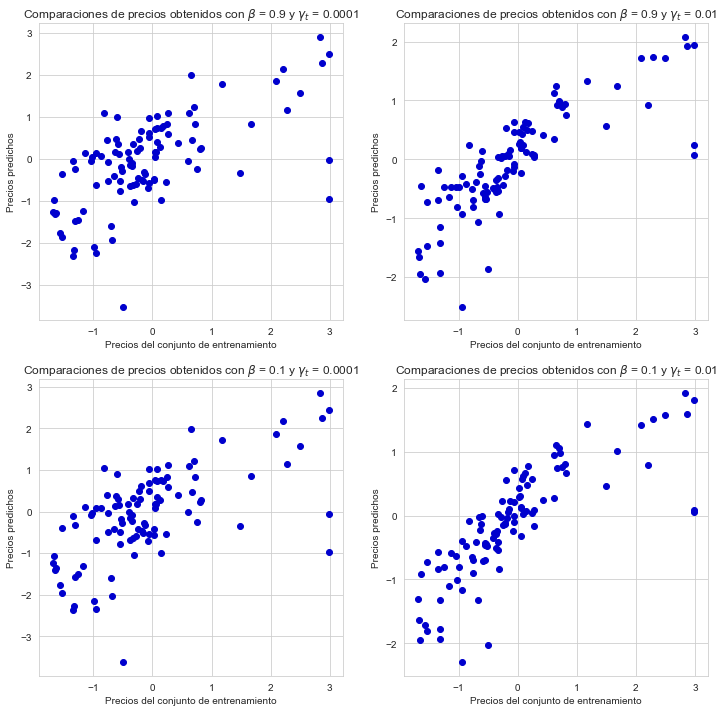

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
axes[0,0].set_title(r'Comparaciones de precios obtenidos con $\beta$ = '+str(B1)+' y $\gamma_t$ = '+str(gamma1))
axes[0,0].plot(y_test,y_pred_B1_g1, 'o', color='mediumblue')
axes[0,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,0].set_ylabel('Precios predichos');

axes[0,1].set_title(r'Comparaciones de precios obtenidos con $\beta$ = '+str(B1)+' y $\gamma_t$ = '+str(gamma2))
axes[0,1].plot(y_test,y_pred_B1_g2, 'o', color='mediumblue')
axes[0,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,1].set_ylabel('Precios predichos');

axes[1,0].set_title(r'Comparaciones de precios obtenidos con $\beta$ = '+str(B3)+' y $\gamma_t$ = '+str(gamma1))
axes[1,0].plot(y_test,y_pred_B3_g1, 'o', color='mediumblue')
axes[1,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,0].set_ylabel('Precios predichos');

axes[1,1].set_title(r'Comparaciones de precios obtenidos con $\beta$ = '+str(B3)+' y $\gamma_t$ = '+str(gamma2))
axes[1,1].plot(y_test,y_pred_B3_g2, 'o', color='mediumblue')
axes[1,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,1].set_ylabel('Precios predichos');

In [45]:
print(ECM1[-1])
print(ECM2[-1])
print(ECM3[-1])


0.8456063372467274
0.4310408280929178
1358938.8273999197


b) Adagrad: El learning rate es variable y se genera de la siguiente manera:
 
\begin{equation}\eta_{i} = \frac{\eta}{\sqrt{v_{i}+c}}, ~ \text{donde } c>0, \eta >0 \end{equation}

\begin{equation}
     v_i = \sum_{j=1}^i ||\nabla_{\theta}f(\theta_{j},x_{j}) ||^2 , ~ v_0 = 0 
\end{equation}

talque $\theta_{i+1} = \theta_{i} - \eta_{i} \cdot \nabla_{\theta} f(\theta,x_{i+1})$


In [46]:
def adagrad(X,y,theta,gamma,n,c):
    m = len(y)
    theta_t=theta.copy()
    v_t = 0
    Theta=np.empty(n,dtype=object)
    for t in range(1,n):
        d= {'1/t': 1/t, 'sin': abs((math.sin(math.pi*(t+0.5)))/(math.pi*(t+0.5)))}
        g = lambda gamma : gamma if type(gamma) in [float,int] else d[gamma]
        i = np.random.randint(0,m)
        X_i = X[i,:]
        y_i = y[i]
        y_p = np.dot(theta_t,X_i)
        grad_i= -2*(y_i - y_p)*X_i
        lr_i = g(gamma)*(1/math.sqrt(v_t+c))

        theta_t = theta_t - lr_i*grad_i
        v_t+= np.linalg.norm(grad_i)**2
        Theta[t]=theta_t
    Theta[0]=theta
    return Theta

In [47]:
n = 10000
gamma1 = 0.0001
gamma2 = 0.01
gamma3 = 1
c1 = 0.01
c2 = 1
c3 = 100
c4 = 10000

In [48]:
new_theta_c1_g1=adagrad(X_train,y_train,theta,gamma1,n,c1)
new_theta_c2_g1=adagrad(X_train,y_train,theta,gamma1,n,c2)
new_theta_c3_g1=adagrad(X_train,y_train,theta,gamma1,n,c3)
new_theta_c4_g1=adagrad(X_train,y_train,theta,gamma1,n,c4)

In [49]:
new_theta_c1_g2=adagrad(X_train,y_train,theta,gamma2,n,c1)
new_theta_c2_g2=adagrad(X_train,y_train,theta,gamma2,n,c2)
new_theta_c3_g2=adagrad(X_train,y_train,theta,gamma2,n,c3)
new_theta_c4_g2=adagrad(X_train,y_train,theta,gamma2,n,c4)

In [50]:
new_theta_c1_g3=adagrad(X_train,y_train,theta,gamma3,n,c1)
new_theta_c2_g3=adagrad(X_train,y_train,theta,gamma3,n,c2)
new_theta_c3_g3=adagrad(X_train,y_train,theta,gamma3,n,c3)
new_theta_c4_g3=adagrad(X_train,y_train,theta,gamma3,n,c4)

In [51]:
ECM_c1_g1=np.zeros(n)
ECM_c2_g1=np.zeros(n)
ECM_c3_g1=np.zeros(n)
ECM_c4_g1=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_theta_c1_g1[k])
    y_pred2 = np.matmul(X_test,new_theta_c2_g1[k])
    y_pred3 = np.matmul(X_test,new_theta_c3_g1[k])
    y_pred4 = np.matmul(X_test,new_theta_c4_g1[k])
    ECM_c1_g1[k]=mean_squared_error(y_test, y_pred1)
    ECM_c2_g1[k]=mean_squared_error(y_test, y_pred2)
    ECM_c3_g1[k]=mean_squared_error(y_test, y_pred3)
    ECM_c4_g1[k]=mean_squared_error(y_test, y_pred4)

In [52]:
ECM_c1_g2=np.zeros(n)
ECM_c2_g2=np.zeros(n)
ECM_c3_g2=np.zeros(n)
ECM_c4_g2=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_theta_c1_g2[k])
    y_pred2 = np.matmul(X_test,new_theta_c2_g2[k])
    y_pred3 = np.matmul(X_test,new_theta_c3_g2[k])
    y_pred4 = np.matmul(X_test,new_theta_c4_g2[k])
    ECM_c1_g2[k]=mean_squared_error(y_test, y_pred1)
    ECM_c2_g2[k]=mean_squared_error(y_test, y_pred2)
    ECM_c3_g2[k]=mean_squared_error(y_test, y_pred3)
    ECM_c4_g2[k]=mean_squared_error(y_test, y_pred4)

In [53]:
ECM_c1_g3=np.zeros(n)
ECM_c2_g3=np.zeros(n)
ECM_c3_g3=np.zeros(n)
ECM_c4_g3=np.zeros(n)
for k in range(n):
    y_pred1 = np.matmul(X_test,new_theta_c1_g3[k])
    y_pred2 = np.matmul(X_test,new_theta_c2_g3[k])
    y_pred3 = np.matmul(X_test,new_theta_c3_g3[k])
    y_pred4 = np.matmul(X_test,new_theta_c4_g3[k])
    ECM_c1_g3[k]=mean_squared_error(y_test, y_pred1)
    ECM_c2_g3[k]=mean_squared_error(y_test, y_pred2)
    ECM_c3_g3[k]=mean_squared_error(y_test, y_pred3)
    ECM_c4_g3[k]=mean_squared_error(y_test, y_pred4)

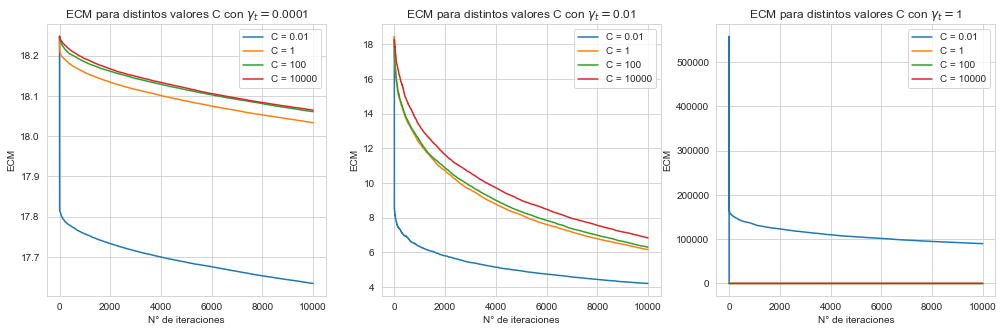

In [54]:
#Gráficos
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(17,5))
j=0
N_=np.arange(j,n)
axes[0].set_title(r"ECM para distintos valores C con $\gamma_t = $"+str(gamma1))
axes[0].plot(N_,ECM_c1_g1[j:,],label='C = '+str(c1));
axes[0].plot(N_,ECM_c2_g1[j:,],label='C = '+str(c2));
axes[0].plot(N_,ECM_c3_g1[j:,],label='C = '+str(c3));
axes[0].plot(N_,ECM_c4_g1[j:,],label='C = '+str(c4));
axes[0].set_xlabel('N° de iteraciones');
axes[0].set_ylabel('ECM');
axes[0].legend(loc='best');

axes[1].set_title(r"ECM para distintos valores C con $\gamma_t = $"+str(gamma2))
axes[1].plot(N_,ECM_c1_g2[j:,],label='C = '+str(c1));
axes[1].plot(N_,ECM_c2_g2[j:,],label='C = '+str(c2));
axes[1].plot(N_,ECM_c3_g2[j:,],label='C = '+str(c3));
axes[1].plot(N_,ECM_c4_g2[j:,],label='C = '+str(c4));
axes[1].set_xlabel('N° de iteraciones');
axes[1].set_ylabel('ECM');
axes[1].legend(loc='best');

axes[2].set_title(r"ECM para distintos valores C con $\gamma_t = $"+str(gamma3))
axes[2].plot(N_,ECM_c1_g3[j:,],label='C = '+str(c1));
axes[2].plot(N_,ECM_c2_g3[j:,],label='C = '+str(c2));
axes[2].plot(N_,ECM_c3_g3[j:,],label='C = '+str(c3));
axes[2].plot(N_,ECM_c4_g3[j:,],label='C = '+str(c4));
axes[2].set_xlabel('N° de iteraciones');
axes[2].set_ylabel('ECM');
axes[2].legend(loc='best');

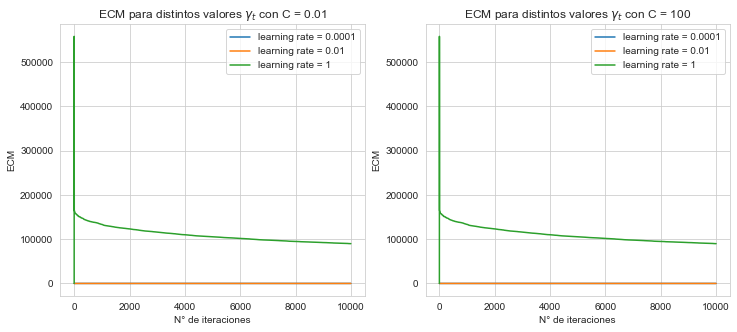

In [55]:
#Gráficos
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12,5))
j=0
N_=np.arange(j,n)
axes[0].set_title(r"ECM para distintos valores $\gamma_t$ con C = "+str(c1))
axes[0].plot(N_,ECM_c1_g1[j:,],label='learning rate = '+str(gamma1));
axes[0].plot(N_,ECM_c1_g2[j:,],label='learning rate = '+str(gamma2));
axes[0].plot(N_,ECM_c1_g3[j:,],label='learning rate = '+str(gamma3));
axes[0].set_xlabel('N° de iteraciones');
axes[0].set_ylabel('ECM');
axes[0].legend(loc='best');

axes[1].set_title(r"ECM para distintos valores $\gamma_t$ con C = "+str(c3))
axes[1].plot(N_,ECM_c3_g1[j:,],label='learning rate = '+str(gamma1));
axes[1].plot(N_,ECM_c3_g2[j:,],label='learning rate = '+str(gamma2));
axes[1].plot(N_,ECM_c1_g3[j:,],label='learning rate = '+str(gamma3));
axes[1].set_xlabel('N° de iteraciones');
axes[1].set_ylabel('ECM');
axes[1].legend(loc='best');

In [56]:
y_pred_c1_g1 = np.matmul(X_test,new_theta_c1_g1[-1])
y_pred_c2_g1 = np.matmul(X_test,new_theta_c2_g1[-1])
y_pred_c3_g1 = np.matmul(X_test,new_theta_c3_g1[-1])
y_pred_c4_g1 = np.matmul(X_test,new_theta_c4_g1[-1])

In [57]:
y_pred_c1_g2 = np.matmul(X_test,new_theta_c1_g2[-1])
y_pred_c2_g2 = np.matmul(X_test,new_theta_c2_g2[-1])
y_pred_c3_g2 = np.matmul(X_test,new_theta_c3_g2[-1])
y_pred_c4_g2 = np.matmul(X_test,new_theta_c4_g2[-1])

In [58]:
y_pred_c1_g3 = np.matmul(X_test,new_theta_c1_g3[-1])
y_pred_c2_g3 = np.matmul(X_test,new_theta_c2_g3[-1])
y_pred_c3_g3 = np.matmul(X_test,new_theta_c3_g3[-1])
y_pred_c4_g3 = np.matmul(X_test,new_theta_c4_g3[-1])

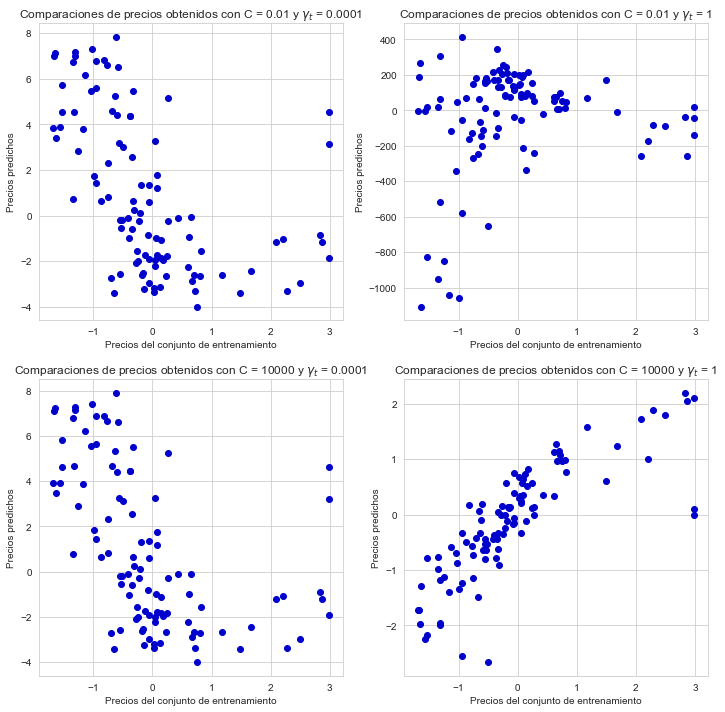

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
axes[0,0].set_title(r'Comparaciones de precios obtenidos con C = '+str(c1)+' y $\gamma_t$ = '+str(gamma1))
axes[0,0].plot(y_test,y_pred_c1_g1, 'o', color='mediumblue')
axes[0,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,0].set_ylabel('Precios predichos');

axes[0,1].set_title(r'Comparaciones de precios obtenidos con C = '+str(c1)+' y $\gamma_t$ = '+str(gamma3))
axes[0,1].plot(y_test,y_pred_c1_g3, 'o', color='mediumblue')
axes[0,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[0,1].set_ylabel('Precios predichos');

axes[1,0].set_title(r'Comparaciones de precios obtenidos con C = '+str(c4)+' y $\gamma_t$ = '+str(gamma1))
axes[1,0].plot(y_test,y_pred_c4_g1, 'o', color='mediumblue')
axes[1,0].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,0].set_ylabel('Precios predichos');

axes[1,1].set_title(r'Comparaciones de precios obtenidos con C = '+str(c4)+' y $\gamma_t$ = '+str(gamma3))
axes[1,1].plot(y_test,y_pred_c4_g3, 'o', color='mediumblue')
axes[1,1].set_xlabel('Precios del conjunto de entrenamiento');
axes[1,1].set_ylabel('Precios predichos');